# Алгоритмическая торговля на примере объёмной дельты (Volume Delta)

**Автор:** Мячин Платон 

---

## Описание проекта

В этом ноутбуке представлено исследование и бэктестинг торговой стратегии на основе **Volume Delta**. Все данные были собраны самостоятельно при помощи собственного **парсера**, реализованного на WebSocket API Bybit. Метрики и индикаторы (Value Area, VPIN, OFI, RF, Kyle’s Lambda, Volume Delta и др.) также написаны с нуля в модуле `functions.py`.

На текущем этапе:
- Фокусируемся исключительно на работе с **Volume Delta** — поиске экстремальных изменений, нормализации относительно средних значений и генерации сигналов входа/выхода.
- Используем формат хранения **parquet** вместо CSV для трёхкратного ускорения чтения и снижения потребления дискового пространства.
- Сигналы тестируются через «галочки» на барах (15 min), а вход/выход по рыночным тикам.

## Возникшие сложности

1. **Перевод CSV → Parquet**  
   Переход к Parquet дал существенное ускорение, но потребовал выстраивания буферизированной записи, синхронизации по датам и фиксации схемы Arrow.

2. **Сдвиг и выравнивание временных рядов**  
   Непросто было согласовать временнýю сетку 15 min—binned индикаторов с тиковыми данными цены и стакана. Приходилось аккуратно выбирать nearest/ffill и следить за NaN.

3. **Динамический TP/SL**  
   Поиск уровней стоп-лосса и тейк-профита на основе ATR/волатильности затронул логику ближайших тиков, что вылилось в серию итераций и баг‑фиксов.

---

> **Дальнейшие планы**:  
> - Расширить эксперимент на остальные индикаторы из `functions.py` (RF, VPIN, OFI, Kyle’s Lambda).  
> - Автоматизировать перебор параметров (Grid Search / Bayesian Optimization).  
> - Интегрировать визуализацию spread/slippage и глубины книги в реальном времени.  

---  


In [1]:
# import sys
# from pathlib import Path          

# sys.path.append(str(Path("src").resolve()))
# import functions

In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import functions #свой файл с функциями чтения данных и расчета
import numpy as np
import math, pyarrow.parquet as pq, os, glob
import pandas as pd

In [3]:
start_date, end_date = '2025-07-17', '2025-08-24'
ticks_by_day, ob_by_day = functions.read_files_by_day(start_date, end_date)

In [4]:
def process_order_flow_imbalance_by_day(odf: pd.DataFrame, period: str) -> pd.Series:
    odf = odf.copy()
    odf['recv_time'] = pd.to_datetime(odf['recv_time'])
    period_ns = pd.to_timedelta(period).value

    series_list = []
    for day, g in odf.groupby(odf['recv_time'].dt.normalize()):
        # anchor = midnight текущего дня
        t0 = day.value  # int64 nanos since epoch
        # last nanosecond of the day
        t_last = (day + pd.Timedelta(days=1) - pd.Timedelta(nanoseconds=1)).value
        max_bins = int((t_last - t0) // period_ns) + 1

        # подготовка входных массивов — только для этой группы
        ts_ns   = g['recv_time'].astype('int64').to_numpy()
        typ     = (g['type'] == 'delta').to_numpy(np.int8)
        side    = (g['side'] == 'Sell').to_numpy(np.int8)
        price   = g['price'].to_numpy(np.float64)
        size    = g['size'].to_numpy(np.float64)

        ofi_vals = functions._ofi_numba(ts_ns, typ, side, price, size, t0, period_ns, max_bins)

        bin_times = pd.to_datetime(t0 + np.arange(max_bins, dtype=np.int64) * period_ns)
        s = pd.Series(ofi_vals, index=bin_times, name='OFI')
        series_list.append(s)

    # Соединяем дни в единый Series (index будет упорядочен по времени)
    return pd.concat(series_list).sort_index()

In [5]:
PERIOD_BIG = '1h'
PERIOD_SMALL = '15min'
PERIOD_TINY = '5min'
STEP = 0.5

indicators_by_day = []
total_len_vpin= 0
total_len_ofi = 0
total_len_ind = 0

for tick_df, ob_df in zip(ticks_by_day, ob_by_day):
    tick_df = tick_df.copy()
    ob_df = ob_df.copy()

    tick_df['recv_time'] = pd.to_datetime(tick_df['recv_time'])
    ob_df['recv_time']  = pd.to_datetime(ob_df['recv_time'])

    price_bar = (
        tick_df.set_index('recv_time')['price']
            .resample('1min', origin='start_day')
            .last()
            .ffill()
            .rename('price')
    )

    ofi = functions.process_order_flow_imbalance(ob_df, PERIOD_TINY)
    va_df     = functions.value_area(tick_df.copy(), PERIOD_SMALL, STEP)
    delta     = functions.volume_delta(tick_df.copy(), PERIOD_SMALL).rename('volume_delta')
    rf        = functions.RF(va_df)

    minute_volume = (#нужно для доп условий индикаторов
        tick_df.set_index('recv_time')['size']
        .resample('1min')
        .sum()
        .reindex(price_bar.index)
        .fillna(0)
        .rename('minute_volume')
    )
    
    cumulative_volume = minute_volume.cumsum().rename('cumulative_volume')
    
    day_df = pd.concat([delta, va_df, price_bar, ofi, rf, minute_volume, cumulative_volume], axis=1)
    
    indicators_by_day.append(day_df)

indicators_df = pd.DataFrame(pd.concat(indicators_by_day, axis=0)) #тут был .sort_index()
indicators_df = indicators_df[~indicators_df.index.duplicated(keep='last')]
indicators_df[['VAH', 'VAL']] = indicators_df[['VAH', 'VAL']].ffill()

pd.set_option('display.max_rows', None)  # Все строки
pd.set_option('display.max_columns', None)  # Все столбцы
pd.set_option('display.width', None)  # Автоподбор ширины
pd.set_option('display.max_colwidth', None)  # Полный текст в ячейках
print(indicators_df)

                     volume_delta  POC_price  POC_volume       VAH       VAL  \
2025-07-20 00:00:00    -54.874001   117738.0   15.640000  117879.5  117732.0   
2025-07-20 00:01:00           NaN        NaN         NaN  117879.5  117732.0   
2025-07-20 00:02:00           NaN        NaN         NaN  117879.5  117732.0   
2025-07-20 00:03:00           NaN        NaN         NaN  117879.5  117732.0   
2025-07-20 00:04:00           NaN        NaN         NaN  117879.5  117732.0   
2025-07-20 00:05:00           NaN        NaN         NaN  117879.5  117732.0   
2025-07-20 00:06:00           NaN        NaN         NaN  117879.5  117732.0   
2025-07-20 00:07:00           NaN        NaN         NaN  117879.5  117732.0   
2025-07-20 00:08:00           NaN        NaN         NaN  117879.5  117732.0   
2025-07-20 00:09:00           NaN        NaN         NaN  117879.5  117732.0   
2025-07-20 00:10:00           NaN        NaN         NaN  117879.5  117732.0   
2025-07-20 00:11:00           NaN       

заполнения времен открытия по индикаторам (на данный момент единственный включенный в исследование индикатор - volume delta, смотрите ниже)

VAH/VAL/POC

In [6]:
def value_area_conditions(indicators_df, horizon='15min', volatile_hours=(10, 22)):

    hour_mask = (indicators_df.index.hour >= volatile_hours[0]) & \
                (indicators_df.index.hour < volatile_hours[1])
    
    va_base = indicators_df.loc[hour_mask, ['VAH', 'VAL', 'price']].copy()
    
    if va_base.empty:
        print("Предупреждение: Нет данных в указанных волатильных часах")
        return indicators_df, pd.DataFrame(), pd.DataFrame()

    future_mean = (
        va_base['price'][::-1]
        .rolling(horizon, min_periods=1)
        .mean()[::-1]
    )
    
    va_base['avg_price'] = future_mean
    
    va_base = va_base.dropna(subset=['VAH', 'VAL'])
    
    P = va_base['price']
    H = va_base['VAH']
    L = va_base['VAL']
    future_mean = va_base['avg_price']
    
    #-----------определение сигналов---------------
    price_near_val = (P <= L * 1.005) & (P >= L * 0.995)
    price_near_vah = (P <= H * 1.005) & (P >= H * 0.995)

    #тренд
    short_trend = P.rolling('30min').mean()
    long_trend = P.rolling('2h').mean()
    is_uptrend = short_trend > long_trend
    is_downtrend = short_trend < long_trend

    val_buy_signals = price_near_val & (P < L) & (P.shift(3) > L.shift(3)) & is_uptrend
    vah_sell_signals = price_near_vah & (P > H) & (P.shift(3) < L.shift(3)) & is_downtrend

    #фильтр по объему -- ДОБАВИТЬ
    if 'minute_volume' in indicators_df.columns:
        volume_filter = indicators_df['minute_volume'] > indicators_df['minute_volume'].rolling('1h').mean()
        val_buy_signals = val_buy_signals & volume_filter
        vah_sell_signals = vah_sell_signals & volume_filter

    #фильтр по волатильности
    volatility = indicators_df['price'].rolling('1h').std()
    volatility_filter = volatility > volatility.rolling('24h').mean()
    val_buy_signals = val_buy_signals & volatility_filter
    vah_sell_signals = vah_sell_signals & volatility_filter

    indicators_df['VAL_buy'] = val_buy_signals
    indicators_df['VAH_sell'] = vah_sell_signals
    #-----------определение сигналов---------------

    delta_price = future_mean - P
    percent_delta_price = (future_mean / P - 1)
    
    # Создание отдельных DataFrame для VAH и VAL статистики
    vah_stats = pd.DataFrame({
        'price_at_signal': P,
        'future_price': future_mean,
        'vah_value': H,
        'delta_price': delta_price,
        'percent_delta': percent_delta_price
    }, index=va_base.index).loc[vah_sell_signals].copy()
    
    val_stats = pd.DataFrame({
        'price_at_signal': P,
        'future_price': future_mean,
        'val_value': L,
        'delta_price': delta_price,
        'percent_delta': percent_delta_price
    }, index=va_base.index).loc[val_buy_signals].copy()
    
    # Добавление дополнительной информации для анализа
    for stats_df, signal_type in [(vah_stats, 'VAH_sell'), (val_stats, 'VAL_buy')]:
        if not stats_df.empty:
            stats_df['signal_type'] = signal_type
            stats_df['hour'] = stats_df.index.hour
            stats_df['weekday'] = stats_df.index.weekday
    
    return indicators_df, vah_stats, val_stats

 отрисовка зависимости изменения цены от VAH, VAL ...

СТАТИСТИКА ПО СИГНАЛАМ VAH/VAL
VAL_buy: рост в 76.8% случаев, среднее изменение: 0.0579%
VAH_sell: падение в 100.0% случаев, среднее изменение: -0.1430%


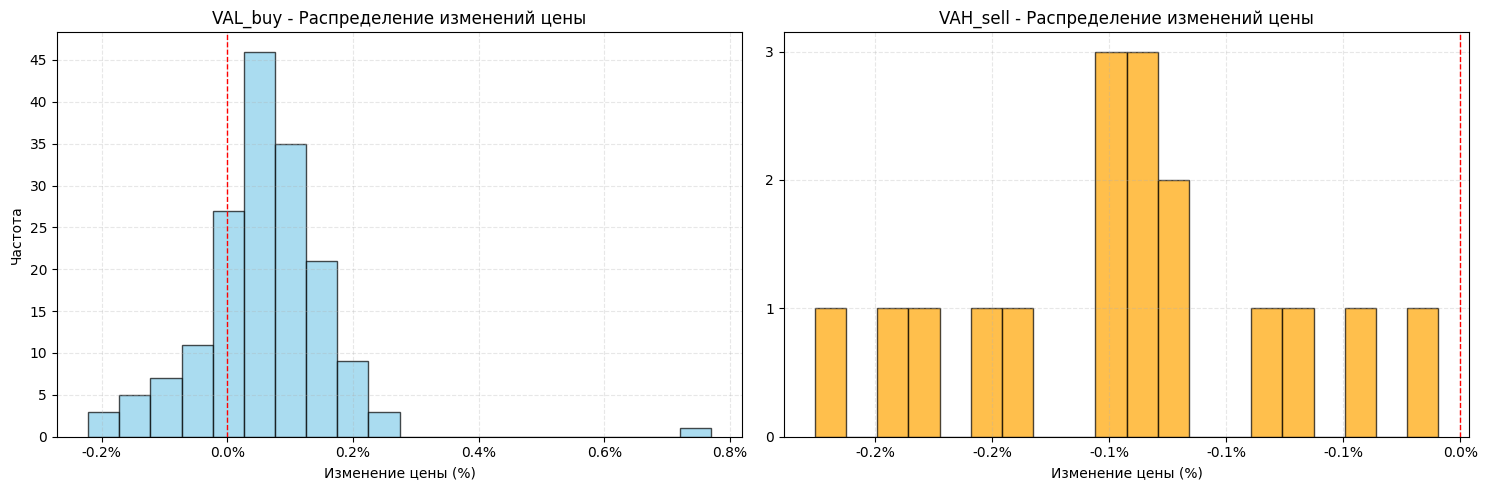

In [7]:
from matplotlib.ticker import MaxNLocator, FuncFormatter

# Получаем данные
indicators_df_, vah_stats, val_stats = value_area_conditions(indicators_df)

# Вывод статистики
print("=" * 50)
print("СТАТИСТИКА ПО СИГНАЛАМ VAH/VAL")
print("=" * 50)

if not val_stats.empty:
    val_change = val_stats['percent_delta']
    print(f"VAL_buy: рост в {(val_change > 0).mean():.1%} случаев, "
          f"среднее изменение: {val_change.mean():.4%}")
else:
    print("VAL_buy: нет данных для анализа")

if not vah_stats.empty:
    vah_change = vah_stats['percent_delta']
    print(f"VAH_sell: падение в {(vah_change < 0).mean():.1%} случаев, "
          f"среднее изменение: {vah_change.mean():.4%}")
else:
    print("VAH_sell: нет данных для анализа")

# Создаем графики только если есть данные
if not val_stats.empty or not vah_stats.empty:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Гистограмма для VAL_buy
    if not val_stats.empty:
        axes[0].hist(val_stats['percent_delta'], bins=20, color='skyblue', alpha=0.7, edgecolor='black')
        axes[0].axvline(0, color='red', linestyle='--', linewidth=1)
        axes[0].set_title('VAL_buy - Распределение изменений цены')
        axes[0].set_xlabel('Изменение цены (%)')
        axes[0].set_ylabel('Частота')
    
    # Гистограмма для VAH_sell
    if not vah_stats.empty:
        axes[1].hist(vah_stats['percent_delta'], bins=20, color='orange', alpha=0.7, edgecolor='black')
        axes[1].axvline(0, color='red', linestyle='--', linewidth=1)
        axes[1].set_title('VAH_sell - Распределение изменений цены')
        axes[1].set_xlabel('Изменение цены (%)')
    
    # Форматирование осей
    for ax in axes:
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1%}'))
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax.grid(True, linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("Нет данных для построения графиков")

ROTATION FACTOR

In [8]:
'''-----------------------анализ RF-----------------------'''
def rf_conditions(indicators_df, n=15, z_window='24h', z_thresh=1.2):
    rf_base = indicators_df[['RF', 'price']]

    future_mean = (
        rf_base['price']
        .rolling('15min', closed='right')
        .mean()
        .shift(-1)  # чтобы смотреть вперёд
    )

    rf_base['avg_price'] = future_mean.where(rf_base['RF'].notna())

    rf_base = rf_base.dropna()
    print(rf_base)

    rf = rf_base['RF']
    P = rf_base['price']
    avg_pr = rf_base['avg_price']

    # Z-score
    rf_z = (rf - rf.rolling(z_window).mean()) / rf.rolling(z_window).std()

    # условия сигналов
    rf_buy  = rf_z < -z_thresh
    rf_sell = rf_z > +z_thresh

    indicators_df['rf_buy']  = rf_buy.fillna(False)
    indicators_df['rf_sell'] = rf_sell.fillna(False)

    # изменение цены через n шагов
    delta_price = (avg_pr - P).rename('delta_price')
    percent_delta_price = (avg_pr / P - 1).rename('percent_delta_price')

    rf_signals = pd.DataFrame({
        'RF': rf,
        'rf_z': rf_z,
        'delta_price': delta_price,
        'percent_delta_price': percent_delta_price,
        'rf_buy': rf_buy,
        'rf_sell': rf_sell
    }).dropna()

    print("rf_buy sum:", rf_buy.sum(), "rf_sell sum:", rf_sell.sum())

    return indicators_df, rf_signals
'''-------------------------------------------------------'''

'-------------------------------------------------------'

визуализация RF

C:\Users\382he\AppData\Local\Temp\ipykernel_16296\3002325516.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rf_base['avg_price'] = future_mean.where(rf_base['RF'].notna())


                            RF          price      avg_price
2025-07-20 00:15:00   0.488722  117714.703125  117764.720312
2025-07-20 00:30:00  10.000000  117687.796875  117743.685938
2025-07-20 00:45:00   1.627660  117700.296875  117729.039583
2025-07-20 01:00:00   3.571429  117905.601562  117908.458854
2025-07-20 01:15:00   0.357576  118033.000000  118000.240625
2025-07-20 01:30:00   2.106383  118026.898438  118063.359896
2025-07-20 01:45:00  10.000000  118035.203125  118018.539583
2025-07-20 02:00:00   6.700000  117854.000000  117962.366667
2025-07-20 02:15:00   0.406015  117917.796875  117886.192187
2025-07-20 02:30:00   3.936170  117840.398438  117883.100521
2025-07-20 02:45:00   0.524590  117922.898438  117901.286979
2025-07-20 03:00:00   9.714286  118010.500000  117990.873438
2025-07-20 03:15:00   7.770833  117983.398438  118031.499479
2025-07-20 03:30:00   0.862434  118015.500000  117973.767187
2025-07-20 03:45:00   0.947368  117983.203125  118063.127083
2025-07-20 04:00:00   0.

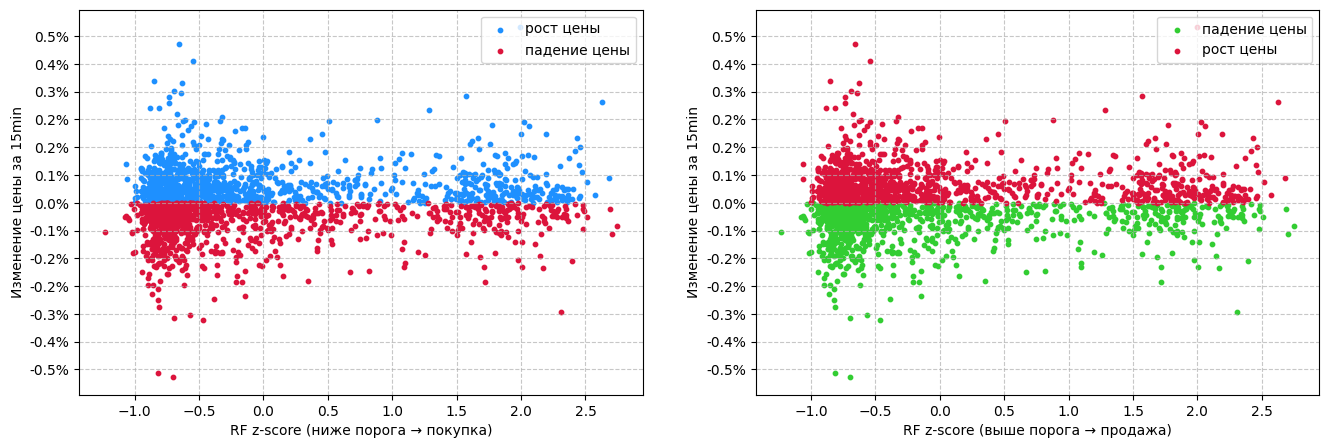

In [9]:
indicators_df_, rf_ratios = rf_conditions(indicators_df)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# для покупок: RF ниже порога (отрицательный z)
rf_buy_case_good = rf_ratios['delta_price'] >= 0
rf_buy_case_bad  = rf_ratios['delta_price'] < 0

# для продаж: RF выше порога (положительный z)
rf_sell_case_good = rf_ratios['delta_price'] <= 0
rf_sell_case_bad  = rf_ratios['delta_price'] > 0

# Лонг-сигналы
axes[0].scatter(
    rf_ratios[rf_buy_case_good]['rf_z'],
    rf_ratios[rf_buy_case_good]['percent_delta_price'],
    color='dodgerblue', s=10, label='рост цены'
)
axes[0].scatter(
    rf_ratios[rf_buy_case_bad]['rf_z'],
    rf_ratios[rf_buy_case_bad]['percent_delta_price'],
    color='crimson', s=10, label='падение цены'
)
axes[0].legend(loc='upper right')
axes[0].set_xlabel('RF z-score (ниже порога → покупка)')

# Шорт-сигналы
axes[1].scatter(
    rf_ratios[rf_sell_case_good]['rf_z'],
    rf_ratios[rf_sell_case_good]['percent_delta_price'],
    color='limegreen', s=10, label='падение цены'
)
axes[1].scatter(
    rf_ratios[rf_sell_case_bad]['rf_z'],
    rf_ratios[rf_sell_case_bad]['percent_delta_price'],
    color='crimson', s=10, label='рост цены'
)
axes[1].legend(loc='upper right')
axes[1].set_xlabel('RF z-score (выше порога → продажа)')

# общий стиль
for ax in axes:
    ax.yaxis.set_major_locator(MaxNLocator(nbins=15))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1%}'))
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_ylabel(f'Изменение цены за {PERIOD_SMALL}', fontsize=10)

# Статистика
buy_cases  = rf_ratios[rf_ratios['rf_buy']]
sell_cases = rf_ratios[rf_ratios['rf_sell']]

buy_total  = len(buy_cases)
sell_total = len(sell_cases)

buy_good = (buy_cases['delta_price'] >= 0).sum()
sell_good = (sell_cases['delta_price'] <= 0).sum()

buy_good_pct  = 100 * buy_good / buy_total if buy_total > 0 else 0
sell_good_pct = 100 * sell_good / sell_total if sell_total > 0 else 0

buy_avg_change  = buy_cases['percent_delta_price'].mean() * 100 if buy_total > 0 else 0
sell_avg_change = sell_cases['percent_delta_price'].mean() * 100 if sell_total > 0 else 0

print(f"Лонг-сигналы (RF < -порог): рост в {buy_good_pct:.1f}% случаев, "
      f"среднее изменение {buy_avg_change:.6f}%")

print(f"Шорт-сигналы (RF > +порог): падение в {sell_good_pct:.1f}% случаев, "
      f"среднее изменение {sell_avg_change:.6f}%")


KYLE'S LAMBDA

In [10]:

'''-----------------------kyle's lambda-----------------------'''
# kl_buy = kl < 0.05
# kl_sell = kl > 0.2

# indicators_df['kl_buy'] = kl_buy.fillna(False)
# indicators_df['kl_sell'] = kl_sell.fillna(False)
'''--------------------------------------------------------------'''


'--------------------------------------------------------------'

In [11]:
P = indicators_df['price']

OFI

In [12]:
'''-----------------------изменение ofi-----------------------'''
def ofi_conditions(indicators_df, threshold_long, threshold_short,
                  cum_window='30min', volatile_hours=(10, 22)):
    """
    volatile_hours: кортеж (start_hour, end_hour) определяющий волатильные часы
    По умолчанию: с 8:00 до 22:00 (14-часовое окно)
    """
    
    # Создаем маску для волатильных часов
    hour_mask = (indicators_df.index.hour >= volatile_hours[0]) & \
                (indicators_df.index.hour < volatile_hours[1])
    
    # Фильтруем данные только по волатильным часам
    ofi_base = indicators_df.loc[hour_mask, ['OFI', 'price']].copy()
    
    # Проверяем, что у нас достаточно данных
    if ofi_base.empty:
        print("Предупреждение: Нет данных в указанных волатильных часах")
        return indicators_df, pd.DataFrame()

    future_mean = (
        ofi_base[::-1]['price']          # переворачиваем индекс
        .rolling('15min', min_periods=1) # теперь окно реально смотрит вперёд во времени
        .mean()
    )[::-1]                              # переворачиваем обратно

    ofi_base['avg_price'] = future_mean.where(ofi_base['OFI'].notna())
    ofi_base = ofi_base.dropna()
    # print(ofi_base)

    ofi_base['cum_ofi'] = ofi_base['OFI'].rolling(cum_window).sum()
    P = ofi_base['price']
    cum_ofi = ofi_base['cum_ofi']

    # разделение на положительные и отрицательные части
    pos_ofi = cum_ofi.clip(lower=0)
    neg_ofi = cum_ofi.clip(upper=0)

    # средние значения для нормализации (по скользящему окну)
    avg_pos = pos_ofi.rolling('24h').mean().shift(1)
    avg_neg = neg_ofi.rolling('24h').mean().shift(1)

    # условия входа (теперь на основе cum_ofi)
    ofi_open_long = abs(cum_ofi / avg_pos.replace(0, np.nan)) >= threshold_long
    ofi_open_short = abs(cum_ofi / avg_neg.replace(0, np.nan)) >= threshold_short

    indicators_df['ofi_open_long'] = ofi_open_long
    indicators_df['ofi_open_short'] = ofi_open_short

    delta_price = (future_mean - P).rename('delta_price')
    percent_delta_price = (future_mean / P - 1).rename('percent_delta_price')

    # DataFrame для анализа сигналов
    ofi_ratios = pd.DataFrame({
        'cum_ofi': cum_ofi,
        'avg_pos': avg_pos,
        'avg_neg': avg_neg,
        'ratio_pos': (pos_ofi / avg_pos.replace(0, np.nan)).clip(upper=50).fillna(0),
        'ratio_neg': (neg_ofi / avg_neg.replace(0, np.nan)).clip(upper=50).fillna(0),
        'delta_price': delta_price,
        'percent_delta_price': percent_delta_price,
        'ofi_open_long': ofi_open_long,
        'ofi_open_short': ofi_open_short
    }).dropna()

    return indicators_df, ofi_ratios
'''------------------------------------------------------------------------------------------------------'''

'------------------------------------------------------------------------------------------------------'

отрисовка OFI

Лонг-сигналы: рост в 72.7% случаев, среднее изменение 0.040429%
Шорт-сигналы: падение в 60.9% случаев, среднее изменение 0.020448%


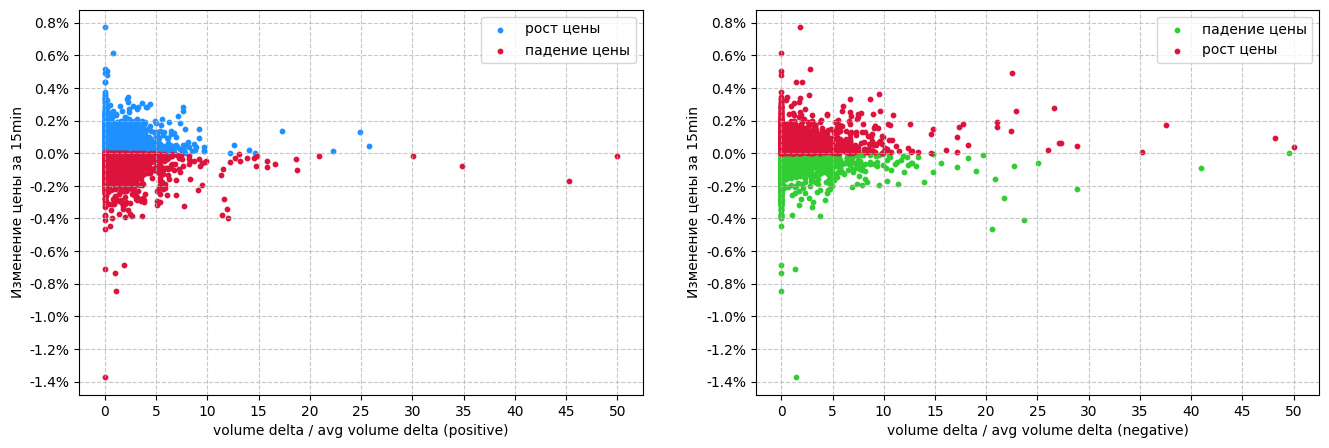

In [13]:
from matplotlib.ticker import MaxNLocator, MultipleLocator, FuncFormatter


indicators_df_, ofi_ratios = ofi_conditions(indicators_df, 40, 40)

fig, axes = plt.subplots(
    1, 2,
    figsize=(16, 5)
)

#при входе в лонг по сигналу с большой положительной дельтой увеличение цены - хорошо, уменьшение - плохо
pos_good_case = ofi_ratios['delta_price'] >= 0
pos_bad_case = ofi_ratios['delta_price'] < 0

#для шорта наоборот
neg_good_case = ofi_ratios['delta_price'] <= 0
neg_bad_case = ofi_ratios['delta_price'] > 0

axes[0].scatter(ofi_ratios[pos_good_case]['ratio_pos'], ofi_ratios[pos_good_case]['percent_delta_price'], color = 'dodgerblue', s=10, label='рост цены')
axes[0].scatter(ofi_ratios[pos_bad_case]['ratio_pos'], ofi_ratios[pos_bad_case]['percent_delta_price'], color = 'crimson', s=10, label='падение цены')
axes[0].legend(loc='upper right')

axes[1].scatter(ofi_ratios[neg_good_case]['ratio_neg'], ofi_ratios[neg_good_case]['percent_delta_price'], color = 'limegreen', s=10, label='падение цены')
axes[1].scatter(ofi_ratios[neg_bad_case]['ratio_neg'], ofi_ratios[neg_bad_case]['percent_delta_price'], color = 'crimson', s=10, label='рост цены')
axes[1].legend(loc='upper right')

axes[0].set_xlabel('volume delta / avg volume delta (positive)')

axes[1].set_xlabel('volume delta / avg volume delta (negative)')

for ax in axes:
    # ось y
    ax.yaxis.set_major_locator(MaxNLocator(nbins=15))  # 15 делений по Y
    
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1%}'))

    # ось х
    ax.xaxis.set_major_locator(MultipleLocator(5))
    
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_ylabel(f'Изменение цены за {PERIOD_SMALL}', fontsize=10)

# Статистика 
long_signals = ofi_ratios[ofi_ratios['ofi_open_long']]
short_signals = ofi_ratios[ofi_ratios['ofi_open_short']]

long_success_rate = len(long_signals[long_signals['percent_delta_price'] >= 0]) / len(long_signals) * 100
short_success_rate = len(short_signals[short_signals['percent_delta_price'] < 0]) / len(short_signals) * 100

print(f"Лонг-сигналы: рост в {long_success_rate:.1f}% случаев, "
      f"среднее изменение {long_signals['percent_delta_price'].mean() * 100:.6f}%")
print(f"Шорт-сигналы: падение в {short_success_rate:.1f}% случаев, "
      f"среднее изменение {short_signals['percent_delta_price'].mean() * 100:.6f}%")

VOLUME DELTA

In [14]:

'''-----------------------изменение volume delta-----------------------'''
def vol_del_conditions(indicators_df, threshold_long, threshold_short):

    neg_delta = indicators_df['volume_delta'].clip(None, 0)#дельта < 0
    pos_delta = indicators_df['volume_delta'].clip(0, None)#дельта > 0

    avg_neg_delta = neg_delta.rolling('24h').mean().shift(1)#cреднее значение дельты < 0
    avg_pos_delta = pos_delta.rolling('24h').mean().shift(1)#cреднее значение дельты > 0

    avg_pos_delta = avg_pos_delta.replace(0, np.nan)
    avg_neg_delta = avg_neg_delta.replace(0, np.nan)
    
    #true false значения по индикаторам
    vol_open_long  = (
        ((indicators_df['volume_delta']) / (avg_pos_delta)) >= threshold_long
    )

    vol_open_short  = (
        ((indicators_df['volume_delta']) / (avg_neg_delta)) >= threshold_short
    )

    #колонка с true false вход/не вход в позицию в конкретный момент
    indicators_df['vol_open_long']  = vol_open_long
    indicators_df['vol_open_short'] = vol_open_short

    n = 3
    #создаю dataframe с двумя отношениями о которых говорил выше (отрицательный к отрицательному и положительный к положительному)
    ofi_ratios = pd.DataFrame({
        'avg_neg': avg_neg_delta,
        'avg_pos': avg_pos_delta,
        'del_neg': neg_delta,
        'del_pos': pos_delta,
        'ratio_pos': (pos_delta / avg_pos_delta).clip(None, 30),#отношения выше 30 можно считать за случайные экстремальные (допустим когда средняя дельта за день -> 0)
        'ratio_neg': (neg_delta / avg_neg_delta).clip(None, 30),
        'delta_price': (P.shift(-n) - P),  # абсолютное изменение цены
        'persent_del_price' : (P.shift(-n))/P - 1
    }).dropna()

    return indicators_df, ofi_ratios

'''------------------------------------------------------------------------------------------------------'''

'------------------------------------------------------------------------------------------------------'

отрисовка графика volumme delta

тут начинается самое интересное, ниже графики на которых
ось x - отношение volume дельта для каждого посчитанного периода к средней volume delta за 24часа (разделены на положительные и отрицательные);
ось y - процент изменения цены между той, при которой было зафиксировано отношения и ценой через 15 минут (PERIOD_SMALL);

In [15]:
from matplotlib.ticker import MaxNLocator, MultipleLocator, FuncFormatter


indicators_df_, ofi_ratios = vol_del_conditions(indicators_df, 12.222222222222221, 30.55555555555557)

fig, axes = plt.subplots(
    1, 2,
    figsize=(16, 5)
)

#при входе в лонг по сигналу с большой положительной дельтой увеличение цены - хорошо, уменьшение - плохо
pos_good_case = ofi_ratios['delta_price'] >= 0
pos_bad_case = ofi_ratios['delta_price'] < 0

#для шорта наоборот
neg_good_case = pos_bad_case
neg_bad_case = pos_good_case

axes[0].scatter(ofi_ratios[pos_good_case]['ratio_pos'], ofi_ratios[pos_good_case]['persent_del_price'], 'price'or = 'dodgerblue', s=10, label='рост цены')
axes[0].scatter(ofi_ratios[pos_bad_case]['ratio_pos'], ofi_ratios[pos_bad_case]['persent_del_price'], 'price'or = 'crimson', s=10, label='падение цены')
axes[0].legend(loc='upper right')

axes[1].scatter(ofi_ratios[neg_good_case]['ratio_neg'], ofi_ratios[neg_good_case]['persent_del_price'], 'price'or = 'limegreen', s=10, label='падение цены')
axes[1].scatter(ofi_ratios[neg_bad_case]['ratio_neg'], ofi_ratios[neg_bad_case]['persent_del_price'], 'price'or = 'crimson', s=10, label='рост цены')
axes[1].legend(loc='upper right')

axes[0].set_xlabel('volume delta / avg volume delta (positive)')

axes[1].set_xlabel('volume delta / avg volume delta (negative)')

for ax in axes:
    # ось y
    ax.yaxis.set_major_locator(MaxNLocator(nbins=15))  # 15 делений по Y
    
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1%}'))

    # ось х
    ax.xaxis.set_major_locator(MultipleLocator(5))
    
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_ylabel(f'Изменение цены за {PERIOD_SMALL}', fontsize=10)

# Статистика 
# --сделать вывод изменений > threshold--
pos_total = len(ofi_ratios[~ofi_ratios['ratio_pos'].isna()])
neg_total = len(ofi_ratios[~ofi_ratios['ratio_neg'].isna()])

pos_good_pct = 100 * pos_good_case.sum() / pos_total if pos_total > 0 else 0
neg_good_pct = 100 * neg_good_case.sum() / neg_total if neg_total > 0 else 0

pos_avg_change = ofi_ratios[pos_good_case | pos_bad_case]['persent_del_price'].mean() * 100
neg_avg_change = ofi_ratios[neg_good_case | neg_bad_case]['persent_del_price'].mean() * 100

print(f"Лонг-сигналы (положительная дельта): рост в {pos_good_pct:.1f}% случаев, "
      f"среднее изменение {pos_avg_change:.4f}%")

print(f"Шорт-сигналы (отрицательная дельта): падение в {neg_good_pct:.1f}% случаев, "
      f"среднее изменение {neg_avg_change:.4f}%")

SyntaxError: invalid syntax (144758733.py, line 19)

получаем графики где визуально можем определить коэффицент отношения выше которого "хороших" случаев заметно больше чем "плохих", записываем эти значения в переменную threshold

вход в позиции

In [16]:
def create_opens(indicators_df):

    open_pos_long = (
        # indicators_df['vol_open_long']
        # & 
        indicators_df['VAL_buy']
        # &
        # indicators_df['ofi_open_long']
        # &
        # indicators_df['rf_buy']
    )

    open_pos_short = (
        # indicators_df['vol_open_short'] 
        # & 
        indicators_df['VAH_sell']
        # &
        # indicators_df['ofi_open_short']
        # &
        # indicators_df['rf_sell']
    )

    #открытие и закрытие позиций    
    longs_open  = indicators_df.index[ open_pos_long.fillna(False) ].unique()
    # longs_open  = None
    shorts_open = indicators_df.index[ open_pos_short.fillna(False) ].unique()

    return longs_open, shorts_open

динамический TP/SL с помощью EMA

EMA


In [17]:
def calc_ema(prices: pd.Series, period: int, prev_ema: float = None):
    alpha = 2 / (period + 1)
    arr = prices.to_numpy()
    ema = np.empty(len(arr))
    ema[:] = np.nan

    if prev_ema is None:
        if len(ema) >= period:
            ema[period-1] = arr[:period].mean()
            start = period
        else:
            ema[len(ema)-1] = arr[:period].mean()
            start = len(ema)
    else:
        ema[0] = alpha * arr[0] + (1 - alpha) * prev_ema
        start = 1

    for i in range(start, len(arr)):
        ema[i] = alpha * arr[i] + (1 - alpha) * ema[i-1]

    return pd.Series(ema, index=prices.index, name=f'EMA{period}'), ema[-1]#это и есть prev_ema т.е последнее значение предыдущего списка


In [18]:
def ema_and_ticks_for_exit(df_today, prev_ema, period_ema: int):
    ticks = df_today.set_index('recv_time')['price']
    ticks = ticks[~ticks.index.duplicated(keep='first')]
    ticks_resampled = ticks.resample('1min').last()

    day_ema, prev_ema = calc_ema(ticks_resampled, period_ema, prev_ema)

    return day_ema, ticks, prev_ema


расчет TP/SL по EMA

In [19]:
def get_nearest_tick(ts, ticks, method):
    pos = ticks.index.get_indexer([ts], method=method)[0]
    return pos

def find_exit_point(open_ts, direction, RISK_REWARD_RATIO, coeff, ticks, ema_df, ema_period):
    ticks_pos = get_nearest_tick(open_ts, ticks, 'nearest')# ТУТ мб РАСХОЖДЕНИЕ МЕЖДУ НАЙДЕННОЙ ЦЕНОЙ И ПРИСВОЕННЫМ ВРЕМЕНЕМ
    entry_price = ticks.iloc[ticks_pos]

    ema_pos = get_nearest_tick(open_ts, ema_df, 'ffill')
    ema_val = ema_df.iloc[ema_pos]

    # считаем SL/TP от EMA
    sl_amount = abs(entry_price - ema_val) * coeff
    tp_amount = sl_amount * RISK_REWARD_RATIO

    future = ticks.iloc[ticks_pos+1:] 

    if direction == 'long':
        sl_price = entry_price - sl_amount
        tp_price = entry_price + tp_amount

        ts_sl = future[future <= sl_price].index.min() if not future[future <= sl_price].empty else None
        ts_tp = future[future >= tp_price].index.min() if not future[future >= tp_price].empty else None
    else:
        sl_price = entry_price + sl_amount
        tp_price = entry_price - tp_amount

        ts_tp = future[future <= tp_price].index.min() if not future[future <= tp_price].empty else None
        ts_sl = future[future >= sl_price].index.min() if not future[future >= sl_price].empty else None

    if ts_sl is not None and ts_tp is not None:
        return (min(ts_sl, ts_tp), sl_price)

    return (ts_sl, sl_price) or (ts_tp, sl_price)#возвращает tuple потому что sl_price понадобится позже в расчете размера позиции

подсчет TP/SL - старая версия

In [20]:
# #нужно переделать логику потому что сейчас он ищет ближайшую цену по 15 минутам а не рил цену

# def get_nearest_tick(ts, ticks):
#     pos = ticks.index.get_indexer([ts], method='nearest')[0]
#     return pos

# #фуекция расчета цены TP/SL и нахождения их временных меток 
# def find_exit_point(open_ts, direction, COEFFICENT, RISK_REWARD_RATIO, ticks, bars):
#     pos = get_nearest_tick(open_ts, ticks)# ТУТ мб РАСХОЖДЕНИЕ МЕЖДУ НАЙДЕННОЙ ЦЕНОЙ И ПРИСВОЕННЫМ ВРЕМЕНЕМ
#     atr = bars.loc[open_ts, 'ATR']

#     # сюда
#     entry_price = ticks.iloc[pos]

#     sl_amount = COEFFICENT * atr
#     tp_amount = RISK_REWARD_RATIO * COEFFICENT * atr

#     future = ticks.iloc[pos+1:] 

#     if direction == 'long':
#         sl_price = entry_price - sl_amount
#         tp_price = entry_price + tp_amount

#         ts_sl = future[future <= sl_price].index.min() if not future[future <= sl_price].empty else None
#         ts_tp = future[future >= tp_price].index.min() if not future[future >= tp_price].empty else None
#     else:
#         sl_price = entry_price + sl_amount
#         tp_price = entry_price - tp_amount

#         ts_tp = future[future <= tp_price].index.min() if not future[future <= tp_price].empty else None
#         ts_sl = future[future >= sl_price].index.min() if not future[future >= sl_price].empty else None

#     if ts_sl is not None and ts_tp is not None:
#         return (min(ts_sl, ts_tp), sl_price)

#     return (ts_sl, sl_price) or (ts_tp, sl_price)#возвращает tuple потому что sl_price понадобится позже в расчете размера позиции

соотнесение временных меток с ценами и создания списков трейдов

In [21]:
def make_trades(longs_open, longs_close, shorts_open, shorts_close, ticks):
    trades = []

    #соотносим время/цену открытия и закрытия и добавляем в список trades[]
    # if (longs_open != None) and (longs_close != None):
    for open_ts, close_ts in zip(longs_open, longs_close):
        if close_ts[0] is None:
            continue

        pos_o = get_nearest_tick(open_ts, ticks, 'nearest')
        pos_c = get_nearest_tick(close_ts[0], ticks, 'nearest')

        actual_open_ts  = ticks.index[pos_o]
        actual_close_ts = ticks.index[pos_c]

        entry_price = ticks.iloc[pos_o]
        exit_price  = ticks.iloc[pos_c]

        trades.append({
            'direction':   'long',
            'entry_time':  actual_open_ts,
            'exit_time':   actual_close_ts,
            'entry_price': entry_price,
            'exit_price':  exit_price,
            'profit':      exit_price - entry_price,
            'return':      (exit_price - entry_price) / entry_price,
            'sl_price':    close_ts[1]
        })

    #то же самое для шортов
    for open_ts, close_ts in zip(shorts_open, shorts_close):
        if close_ts[0] is None:
            continue

        pos_o = get_nearest_tick(open_ts, ticks, 'nearest')
        pos_c = get_nearest_tick(close_ts[0], ticks, 'nearest')

        actual_open_ts  = ticks.index[pos_o]
        actual_close_ts = ticks.index[pos_c]

        entry_price = ticks.iloc[pos_o]
        exit_price  = ticks.iloc[pos_c]

        trades.append({
            'direction':   'short',
            'entry_time':  actual_open_ts,
            'exit_time':   actual_close_ts,
            'entry_price': entry_price,
            'exit_price':  exit_price,
            'profit':      entry_price - exit_price,
            'return':      (entry_price - exit_price) / entry_price,
            'sl_price':    close_ts[1]
    })
    
    return trades

fill order

In [22]:
def fill_order(odf, entry_time, size, direction):
    if odf.empty:
        return None, None

    recv_times = odf['recv_time']

    # Если нужного времени в этом дне нет — пропускаем
    if entry_time < recv_times.iloc[0] or entry_time > recv_times.iloc[-1]:
        return None, None

    # 1. Находим стартовую позицию
    pos = recv_times.searchsorted(entry_time, side='left')
    if pos >= len(recv_times):
        print("❌ Нет тик данных после entry_time:", entry_time)
    else:
        nearest_time = recv_times.iloc[pos]
        print("✅ Ближайший тик:", nearest_time)

    # Корректируем позицию для ближайшего времени
    if pos == len(odf):
        pos = len(odf) - 1
    elif pos > 0:
        diff_prev = abs(recv_times.iloc[pos-1] - entry_time)
        diff_next = abs(recv_times.iloc[pos] - entry_time)
        if diff_prev < diff_next:
            pos -= 1

    # 2. Определяем сторону сделки
    target_side = 'Sell' if direction == 'long' else 'Buy'

    # 3. Ищем достаточный объём
    curr_size = 0.0
    for i in range(pos, len(odf)):
        row = odf.iloc[i]
        if row['side'] == target_side:
            curr_size += float(row['size'])
            if curr_size >= size:
                return float(row['price']), row['recv_time']

    return None, None

создание price_series

In [23]:
def make_price_series(ticks_by_day):
    price_parts = []
    for day_df in ticks_by_day:
        if not day_df.empty:
            price_parts.append(day_df.set_index('recv_time')['price'])
    return pd.concat(price_parts)

подсчет доходности

In [24]:
def equity_calc(trades):
    price_ser = make_price_series(ticks_by_day)
    times  = [trades[0]['entry_time'] if trades else ticks_by_day[0]['recv_time'].iloc[0]]
    DEPOSIT = 10_000
    RISK_PERCENT = 0.01   # 1%
    FEE          = 0.00075  # комиссия bybit

    equity = [DEPOSIT]

    for tr in trades:
        entry_price = tr['entry_price']
        entry_time = tr['entry_time']
        sl_price    = tr['sl_price'] 
        exit_price  = tr['exit_price']
        exit_time  = tr['exit_time']
        direction   = tr['direction']

        # долларовый риск
        risk_usd = equity[-1] * RISK_PERCENT

        for day_idx, day_df in enumerate(ob_by_day):
            act_entry_price, act_entry_time = fill_order(day_df, entry_time, risk_usd, direction)
            if act_entry_price is not None:
                break

        # поиск выхода начиная с того же дня
        act_exit_price, act_exit_time = None, None
        for day_df in ob_by_day[day_idx:]:
            act_exit_price, act_exit_time = fill_order(day_df, exit_time, risk_usd, direction)
            if act_exit_price is not None:
                break
            
        if (act_entry_price == None) & (act_exit_price == None):
            print('обе цены None для времени входа', entry_time, 'act entry time: ', act_entry_time)
            continue

        #расстояние до SL
        stop_distance = abs(entry_price - sl_price)
        if stop_distance == 0:
            # защита от деления на ноль
            position_size = 0
        else:
            position_size = risk_usd / stop_distance

        #PnL, в контрактах умножаем на разницу цен
        if direction == 'long':
            pnl = position_size * (act_exit_price - act_entry_price)
        else:  # short
            pnl = position_size * (act_entry_price - act_exit_price)

        #комиссия на открытие+закрытие
        notional_entry = position_size * act_entry_price
        notional_exit  = position_size * act_exit_price
        commission = (notional_entry + notional_exit) * FEE

        net_pnl = pnl - commission

        # записываем новое equity
        equity.append(equity[-1] + net_pnl)

        # times.append(tr['exit_time'])
        times.append(act_entry_time)

    #расчёт buy&hold
    bh_price = price_ser
    bh_equity = DEPOSIT * (bh_price / bh_price.iloc[0])

    return equity, bh_equity, times



TP/SL по order flow

In [ ]:
def make_range_df(price, odf):
    pos = odf['price'].get_indexer([price], method='nearest')

def find_exit_with_of(odf, entry_time, size, direction, delta_percent = 0.02):
    if odf.empty:
        return None, None

    recv_times = odf['recv_time']

    #если нужного времени в этом дне нет — пропускаем
    if entry_time < recv_times.iloc[0] or entry_time > recv_times.iloc[-1]:
        return None, None

    pos = recv_times.searchsorted(entry_time, side='left')
    if pos >= len(recv_times):
        print("❌ Нет тик данных после entry_time:", entry_time)
    else:
        nearest_time = recv_times.iloc[pos]
        print("Ближайший тик для TP/SL :", nearest_time)

    curr_price = odf['price'].iloc[pos]

    ceil_price = curr_price * (1 + delta_percent)
    floor_price = curr_price * (1 - delta_percent)

    # ищем первое касание сверху (ceil) и снизу (floor) ПОСЛЕ entry_time
    ceil_hit = odf.iloc[:pos][odf['price'].iloc[:pos] <= ceil_price]
    floor_hit = odf.iloc[:pos][odf['price'].iloc[:pos] >= floor_price]

    ceil_ts = ceil_hit['recv_time'].iloc[-1] if not ceil_hit.empty else None
    floor_ts = floor_hit['recv_time'].iloc[-1] if not floor_hit.empty else None

    # диапазон данных между entry и ближайшим достижением одного из уровней
    end_ts = None
    if ceil_ts and floor_ts:
        start_ts = min(ceil_ts, floor_ts)
    elif ceil_ts:
        start_ts = ceil_ts
    elif floor_ts:
        start_ts = floor_ts

    range_df = odf[(odf['recv_time'] <= entry_time) & (odf['recv_time'] >= start_ts)] if end_ts else None

    return ceil_ts, floor_ts, range_df

грид серч (очень долгий)

In [25]:
# vol_window = ['12h', '24h']
# coefficent = np.linspace(1.0, 4.0, num=10, endpoint=True)
# RRR = np.linspace(1.0, 4.0, num=10, endpoint=True)
# thresholds_long = np.linspace(10.0, 30.0, num=10, endpoint=True)
# thresholds_short = np.linspace(15.0, 35.0, num=10, endpoint=True)

# strat_returns = {
#         'equity': [],
#         'RRR': [],
#         'coefficent': [],
#         'window': [],
#         'threshold_long': [],
#         'threshold_short': [],
# }

# precomputed_atr = {}
# for window in vol_window:
#     bars, ticks = calculate_atr(window, df)
#     precomputed_atr[window] = (bars, ticks)

# for window in vol_window:
#     for coef in coefficent:
#         for rrr in RRR:
#             for threshold_long in thresholds_long:
#                 for threshold_short in thresholds_short:
                    
#                     indicators_df_, ofi_ratios = vol_del_conditions(indicators_df, threshold_long, threshold_short)
#                     longs_open, shorts_open = create_opens(indicators_df_)
#                     bars, ticks = precomputed_atr[window]

#                     longs_close  = [find_exit_point(ts, 'long', coef, rrr, ticks, bars)  for ts in longs_open]
#                     shorts_close = [find_exit_point(ts, 'short', coef, rrr, ticks, bars) for ts in shorts_open]

#                     trades = make_trades(longs_open, longs_close, shorts_open, shorts_close, ticks)

#                     equity, bh_equity, times =  equity_calc(trades)

#                     strat_returns['equity'].append((equity[-1]-equity[0])/100)
#                     strat_returns['RRR'].append(rrr)
#                     strat_returns['coefficent'].append(coef)
#                     strat_returns['window'].append(window)
#                     strat_returns['threshold_long'].append(threshold_long)
#                     strat_returns['threshold_short'].append(threshold_short)

# max_eq    = max(strat_returns['equity'])
# max_index = strat_returns['equity'].index(max_eq)
# print(
#     f"Максимальный доход: {max_eq:.5f}%\n"
#     f"RRR: {strat_returns['RRR'][max_index]}\n"
#     f"window: {strat_returns['window'][max_index]}\n"
#     f"coefficent: {strat_returns['coefficent'][max_index]}"
#     f"сколько бабок в чистом виде: {max_eq*100} "
#     f'threshold_long: {strat_returns['threshold_long'][max_index]}'
#     f'threshold_short: {strat_returns['threshold_short'][max_index]}'
# )

вызов функций с лучшими параметрами

In [29]:
COEFFICENT = 3
RRR = 2

indicators_df_, ofi_ratios = vol_del_conditions(indicators_df, 4, 7)
indicators_df_, ofi_ratios = ofi_conditions(indicators_df_, 40, 40)
longs_open, shorts_open = create_opens(indicators_df_)

ema_series_all = []
ticks_all = []

for i, df_day in enumerate(ticks_by_day):
    if i == 0:
        ema_series, ticks_df, prev_ema = ema_and_ticks_for_exit(df_day, None, 1500)
    else:
        ema_series, ticks_df, prev_ema = ema_and_ticks_for_exit(df_day, prev_ema, 1500)

    ema_series_all.append(ema_series)
    ticks_all.append(ticks_df)

# Склеиваем результат
ema_all = pd.concat(ema_series_all)
ticks_all = pd.concat(ticks_all)

ema_all = ema_all[~ema_all.index.duplicated(keep='first')]
ticks_all = ticks_all[~ticks_all.index.duplicated(keep='first')]

longs_close = [find_exit_point(ts, 'long', RRR, COEFFICENT, ticks_all, ema_all, 1500) for ts in longs_open]
shorts_close = [find_exit_point(ts, 'short', RRR, COEFFICENT, ticks_all, ema_all, 1500) for ts in shorts_open]
print(longs_close)

trades = make_trades(longs_open, longs_close, shorts_open, shorts_close, ticks_all)

equity, bh_equity, times =  equity_calc(trades)


[(None, np.float64(nan)), (None, np.float64(nan)), (None, np.float64(nan)), (None, np.float64(nan)), (None, np.float64(nan)), (None, np.float64(nan)), (None, np.float64(nan)), (None, np.float64(nan)), (None, np.float64(nan)), (None, np.float64(nan)), (Timestamp('2025-07-25 13:37:58.551000'), np.float64(116307.8937663816)), (Timestamp('2025-07-21 19:33:48.809000'), np.float64(116776.87409330411)), (Timestamp('2025-07-24 14:58:39.743000'), np.float64(116771.75524231137)), (Timestamp('2025-07-25 13:41:02.180000'), np.float64(115763.8383244395)), (Timestamp('2025-07-25 13:37:58.551000'), np.float64(116612.8884980928)), (Timestamp('2025-07-25 13:37:58.551000'), np.float64(116543.05924488747)), (Timestamp('2025-07-25 13:37:58.551000'), np.float64(116666.33540484266)), (None, np.float64(108185.50575117722)), (None, np.float64(108054.0690161736)), (None, np.float64(106708.70800571887)), (None, np.float64(109323.31577516434)), (None, np.float64(108740.93473845493)), (None, np.float64(109694.509

отрисовка точек входа на цене

KeyError: 'VPIN'

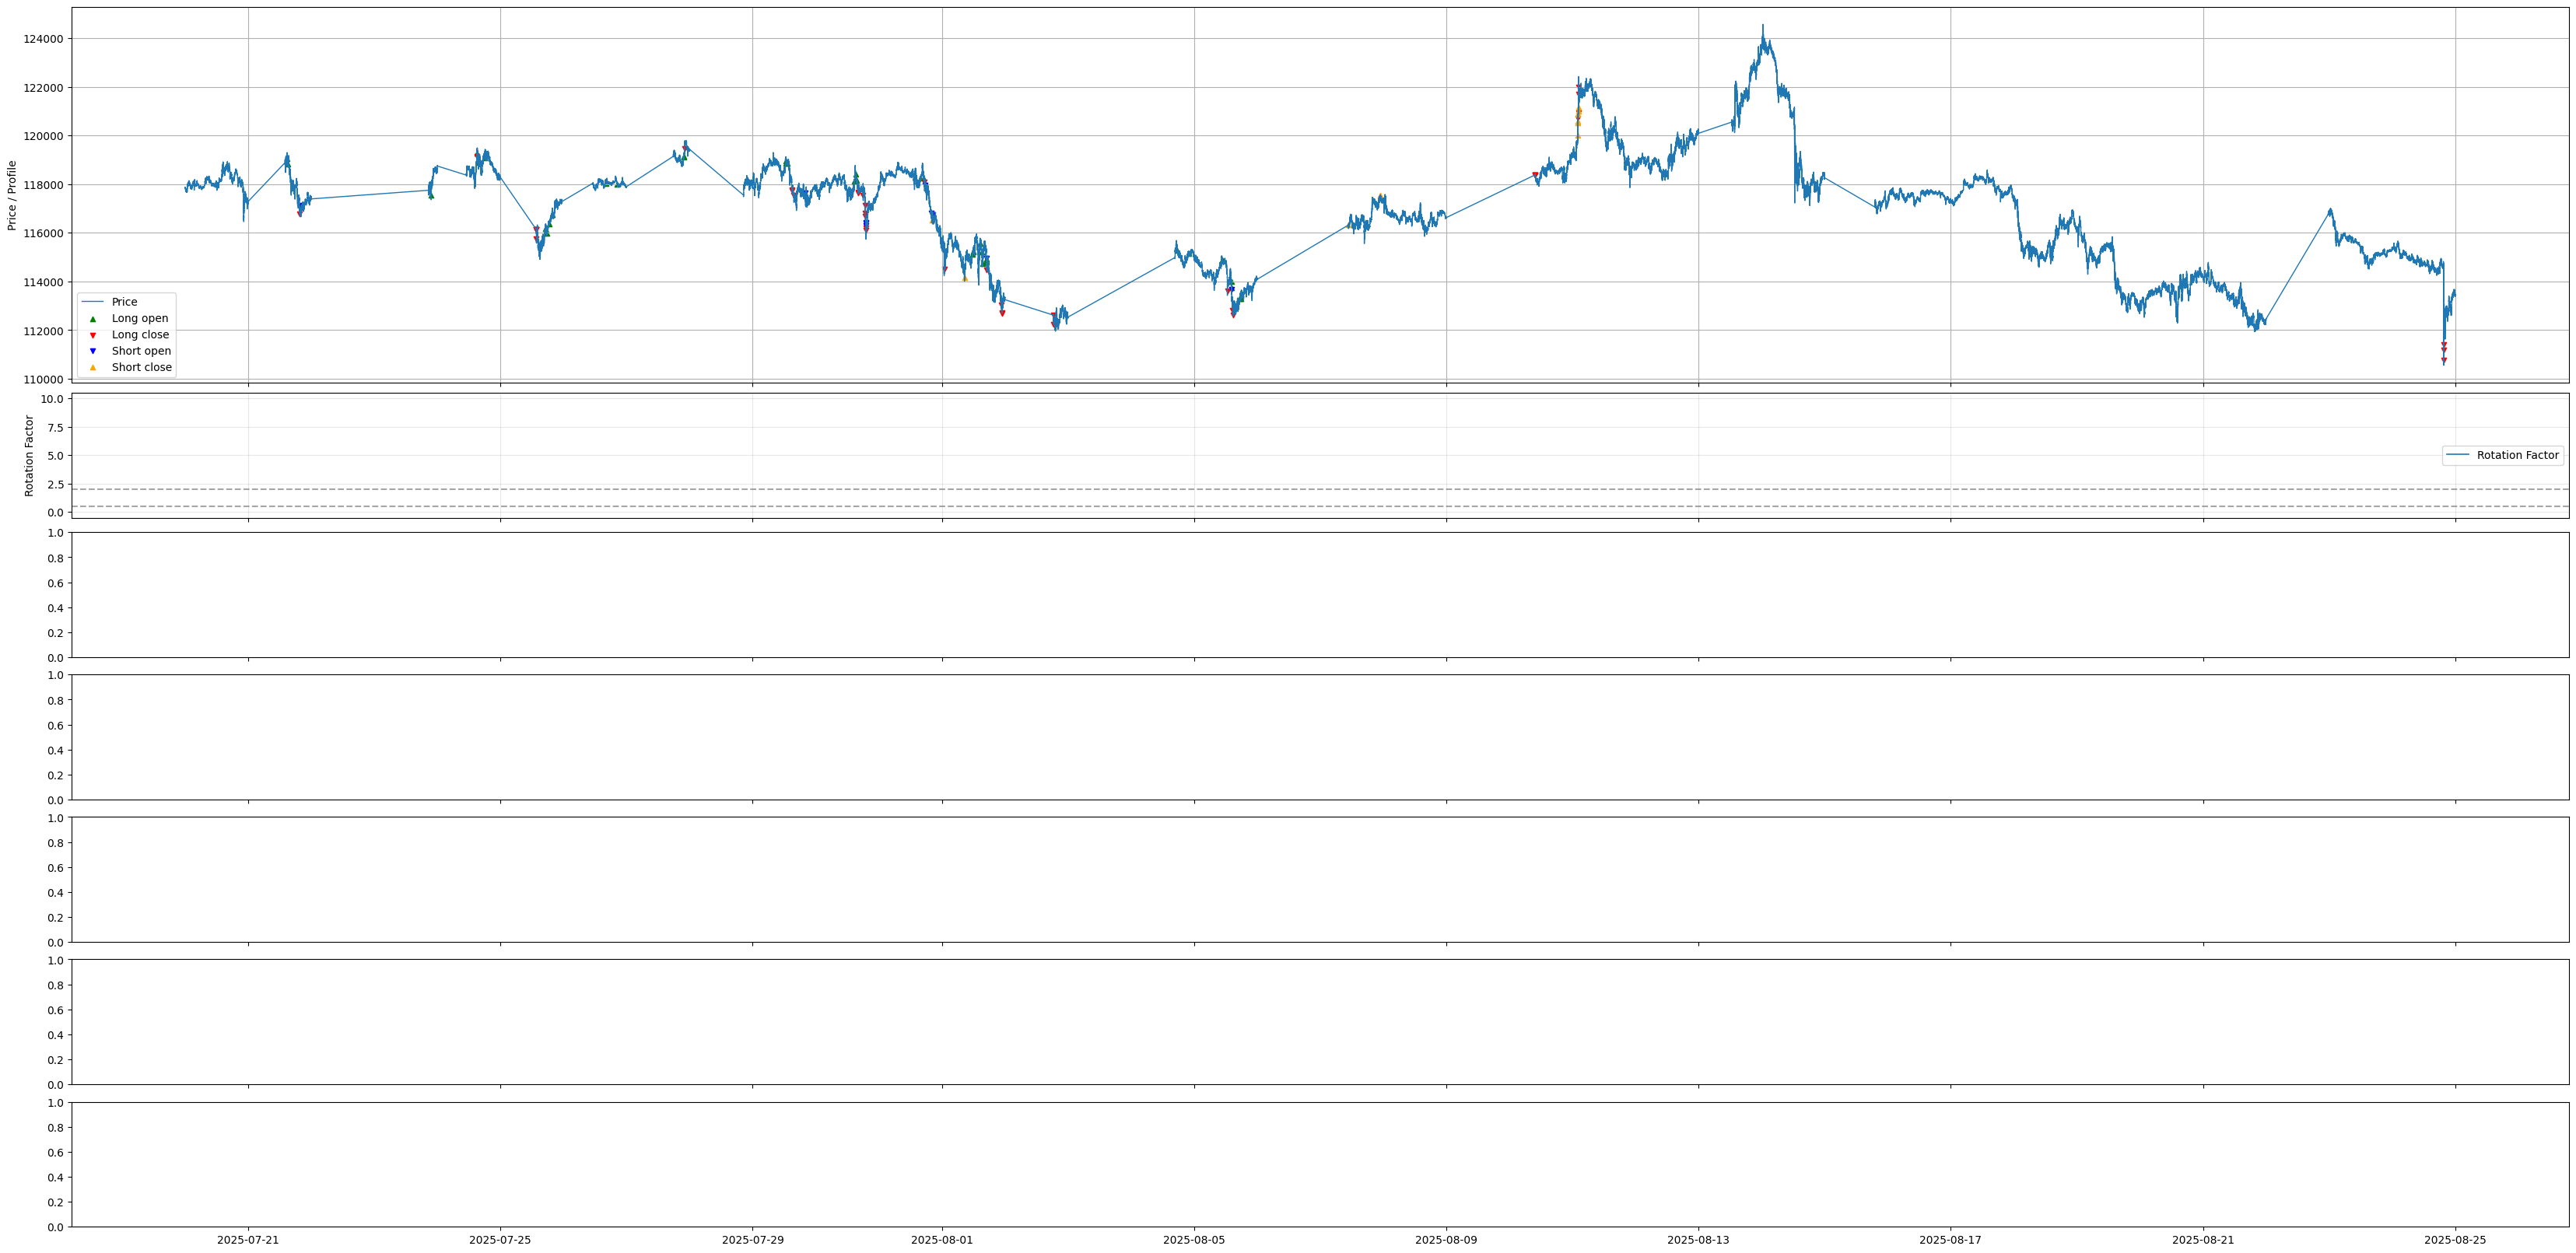

In [30]:
df = pd.concat(ticks_by_day, ignore_index=True)
df['recv_time']  = pd.to_datetime(df['recv_time'])

fig, axes = plt.subplots(
    7, 1,
    figsize=(33, 16),
    constrained_layout=True,
    sharex=True,
    gridspec_kw={'height_ratios': [3, 1, 1, 1, 1, 1, 1]}
)
ax0 = axes[0]

# цена
ax0.plot(df['recv_time'], df['price'], label='Price', linewidth=1)
# ax0.plot(indicators_df.index, indicators_df['VAH'], label='VAH')
# ax0.plot(indicators_df.index, indicators_df['VAL'], label='VAL')

# 1)разделяем trades на два списка
trades_long  = [t for t in trades if t['direction'] == 'long']
trades_short = [t for t in trades if t['direction'] == 'short']

# извлекаем отдельно entry/exit времена и цены для каждого направления
long_open_times  = [t['entry_time']  for t in trades_long]
long_open_prices = [t['entry_price'] for t in trades_long]
long_close_times  = [t['exit_time']  for t in trades_long]
long_close_prices = [t['exit_price'] for t in trades_long]

short_open_times  = [t['entry_time']   for t in trades_short]
short_open_prices = [t['entry_price']  for t in trades_short]
short_close_times  = [t['exit_time']   for t in trades_short]
short_close_prices = [t['exit_price']  for t in trades_short]

#наносим на график

ax0.scatter(long_open_times,  long_open_prices,  marker='^', color='g', s=20, label='Long open')
ax0.scatter(long_close_times, long_close_prices, marker='v', color='r', s=20, label='Long close')

ax0.scatter(short_open_times,  short_open_prices,  marker='v', color='b',      s=20, label='Short open')
ax0.scatter(short_close_times, short_close_prices, marker='^', color='orange', s=20, label='Short close')

ax0.set_ylabel("Price / Profile")
ax0.legend(loc='lower left')
ax0.grid(True)

indicators = ['RF','VPIN','OFI','Kyle_Lambda','volume_delta', 'cum_delta']
titles = ['Rotation Factor', 'VPIN', 'Order Flow Imbalance', "Kyle's Lambda", 'Volume Delta', 'Cummulutive Delta']

for i, indicator in enumerate(indicators, start=1):
    if indicator == 'volume_delta':
        colors = np.where(indicators_df[indicator] >= 0, 'green', 'red')
        axes[i].bar(indicators_df.index, indicators_df[indicator], color=colors, alpha=0.7, width=0.01)
        axes[i].axhline(0, color='gray', linestyle='-', alpha=0.5)
    else:
        axes[i].plot(indicators_df.index, indicators_df[indicator], label=titles[i-1], linewidth=1.2)
    
    #ключевые уровни для каждого индикатора
    if indicator == 'RF':
        axes[i].axhline(0.5, color='gray', linestyle='--', alpha=0.7)
        axes[i].axhline(2.0, color='gray', linestyle='--', alpha=0.7)
    elif indicator == 'VPIN':
        axes[i].axhline(0.1, color='gray', linestyle='--', alpha=0.7)
        axes[i].axhline(0.3, color='gray', linestyle='--', alpha=0.7)
    elif indicator == 'Kyle_Lambda':
        axes[i].axhline(0.05, color='gray', linestyle='--', alpha=0.7)
        axes[i].axhline(0.2, color='gray', linestyle='--', alpha=0.7)
    elif indicator == 'OFI':
        axes[i].axhline(0, color='gray', linestyle='-', alpha=0.5)
    elif indicator == 'cum_delta':
        axes[i].axhline(0, color='gray', linestyle='-', alpha=0.5)
    
    axes[i].set_ylabel(titles[i-1])
    axes[i].grid(True, alpha=0.3)
    axes[i].legend(loc='best')

for ax in axes:
    #локатор дат каждые 3 часа
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=3))
    
    #формат дата время
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
    
    #дополнительные минорные деления (каждый час)
    ax.xaxis.set_minor_locator(mdates.HourLocator(interval=1))
    
    #поворот меток
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.subplots_adjust(bottom=0.15)
# plt.tight_layout()
plt.show()

отрисовка дохода

In [31]:
# fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(14,4),sharex=True, sharey=False)

# # Стратегия
# pts = sorted(zip(times, equity), key=lambda x: x[0])
# times_sorted, equity_sorted = zip(*pts)

# ax0.plot(times_sorted, equity_sorted, label='Strategy Equity', linewidth=2)
# ax0.set_title("Strategy")
# ax0.set_xlabel("Time")
# ax0.set_ylabel("Equity, USD")
# ax0.legend()
# ax0.grid(True)
# # Сузим диапазон Y, чтобы мелкие изменения было видно:
# y_min = min(equity)*0.9995
# y_max = max(equity)*1.0005
# ax0.set_ylim(y_min, y_max)

# # Buy & Hold
# ax1.plot(bh_equity.index, bh_equity.values, 
#          label='Buy & Hold', color='orange', linewidth=2)
# ax1.set_title("Buy & Hold")
# ax1.set_xlabel("Time")
# ax1.legend()
# ax1.grid(True)


# plt.tight_layout()
# plt.show()

print(f'Strategy returns:\n{(equity[-1]-equity[0])/100:.3f} %, Balance: {equity[-1]:.3f}, Max drawdown: {min(equity)} ({(min(equity) - equity[0])/100:.3f}%)')
print(f'Buy&Hold returns:\n{(bh_equity[-1]-bh_equity[0])/100:.3f} %, Balance: {bh_equity[-1]:.3f}')


Strategy returns:
-20.679 %, Balance: 7932.054, Max drawdown: 7423.693694891902 (-25.763%)
Buy&Hold returns:
-3.721 %, Balance: 9627.874


C:\Users\382he\AppData\Local\Temp\ipykernel_16296\1179482841.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Buy&Hold returns:\n{(bh_equity[-1]-bh_equity[0])/100:.3f} %, Balance: {bh_equity[-1]:.3f}')
